In [ ]:
#drive mount
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
#라이브러리 import
import numpy as np 
import pandas as pd 
import tensorflow as tf
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import matplotlib.image as img

In [ ]:
import os 
import imageio 

#dota_ver1에 이미지 몇개가 있는지 확인
path =''
image_path = os.path.join(path,'gdrive/MyDrive/dataset/dota_ver1/images/')
image_list = os.listdir(image_path)
image_list = [image_path+i for i in image_list]
image_list = sorted(image_list)

print("number of images is : {} ".format(len(image_list)))

#labeltxt에 레이블 몇개가 있는지 확인
label_path = os.path.join(path,'gdrive/MyDrive/dataset/labeltxt/')
label_list = os.listdir(label_path)
label_list = [label_path+i for i in label_list]
label_list = sorted(label_list)

print("number of labels is : {} ".format(len(label_list)))

number of images is : 1411 
number of labels is : 1411 


In [ ]:
#첫번째 사진의 크기가 몇일까
n = 0  
img  = imageio.imread(image_list[n])
print(img.shape)

(5502, 3875, 3)


In [ ]:
#사진에 vehicle 위치를 찍어보기
import cv2
poly1 = np.array([[658, 242], [648, 237], [657, 222], [667, 225]])
poly2 = np.array([[612, 341], [607, 336], [613, 324], [621, 329]])
poly3 = np.array([[711, 140], [718, 141], [712, 157], [706, 154]])

img2 = img.copy()
img2 = cv2.polylines(img2, [poly1], False, (0, 0, 255), 50)


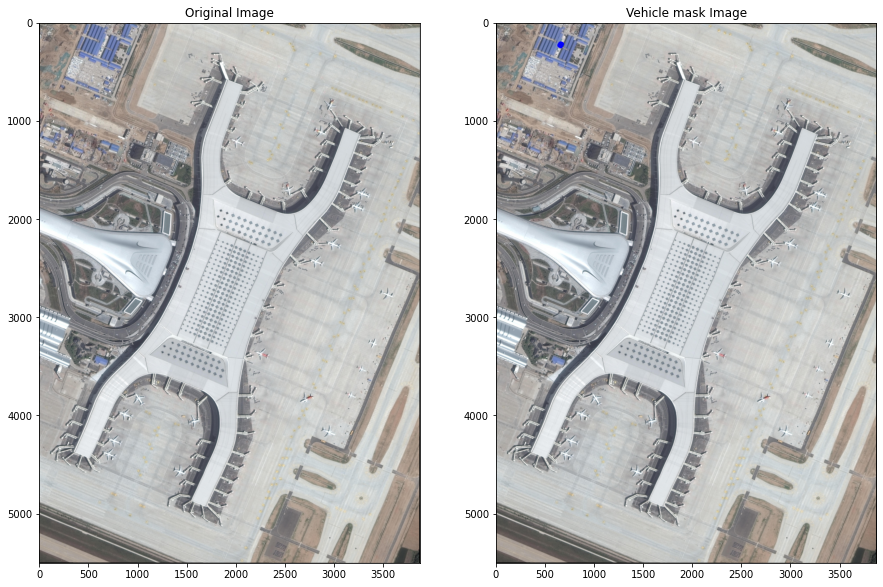

In [ ]:
fig ,arr  = plt.subplots(1,2,figsize=(15,10))
arr[0].imshow(img)
arr[0].set_title('Original Image')
arr[0].axhline(4.0, 0.1, 0.9, color='lightgray', linestyle='--', linewidth=2)

arr[1].imshow(img2)
arr[1].set_title('Vehicle mask Image')
arr[1].axhline(4.0, 0.1, 0.9, color='lightgray', linestyle='--', linewidth=2)


In [ ]:
#labeltxt 요소의 구성을 살펴보기
f = open('/content/gdrive/MyDrive/dataset/labeltxt/P0096.txt', "r")
line = f.read().split('\n')
print(line)

['imagesource:GoogleEarth', 'gsd:0.132612071701', '685 1067 695 1080 674 1101 661 1087 small-vehicle 0', '682 1048 690 1060 667 1077 658 1065 small-vehicle 0', '530 1106 541 1114 525 1140 512 1131 small-vehicle 0', '121 283 693 283 693 858 121 858 roundabout 0', '']


In [ ]:
#label을 붙여주고 yolo의 학습에 적합한 중간형태로 변환 (label, cx, cy, w, h)
label_dict = {"plane":1, "ship":2, "storage-tank":3, "baseball-diamond":4, "tennis-court":5, "basketball-court":6, "ground-track-field":7, "harbor":8, "bridge":9, "large-vehicle":10, "small-vehicle":11, "helicopter":12, "roundabout":13, "soccer-ball-field":14, "swimming-pool":15}

def readf(path,filename):
    f = open(path, "r")
    line = f.read().split('\n')
    line.pop(len(line)-1)
    line.pop(0)
    line.pop(0)
    line_array=[]
    f2= open(filename, 'w')
    for i in range(len(line)):
        line_array=line[i].split(" ")
        line_array.pop(len(line_array)-1)
        label=label_dict[line_array[len(line_array)-1]]
        line_array.pop(len(line_array)-1)
        line_array = [int(numeric_string) for numeric_string in line_array]
        cx = (line_array[0]+line_array[2]+line_array[4]+line_array[6])/4
        cy = (line_array[1]+line_array[3]+line_array[5]+line_array[7])/4
        w = max(line_array[0], line_array[2], line_array[4], line_array[6])-min(line_array[0], line_array[2], line_array[4], line_array[6])
        h = max(line_array[1], line_array[3], line_array[5], line_array[7])-min(line_array[1], line_array[3], line_array[5], line_array[7])
        
        txt = str(label)+" " + str(cx) + " " + str(cy) + " " + str(w)+ " " + str(h) + "\n"
        f2.write(txt)
    f2.close()
    f.close()

    

In [ ]:
#labeltxt의 주소들 가져오기
import os
listdir=os.listdir('/content/gdrive/MyDrive/dataset/labeltxt')
listdir=sorted(listdir)

In [ ]:
#new_label 폴더에 (label, cx, cy, w, h)형식의 label들로 바꾼 값들을 저장. (new_label 폴더까지는 만들어줘야함)
for _,data in enumerate(listdir):
    readf('/content/gdrive/MyDrive/dataset/labeltxt/'+data,'/content/gdrive/MyDrive/dataset/new_label/'+ data)


In [ ]:
#각 이미지들의 주소를 불러들인 후, 각 이미지들의 크기 확인, listW에 사진의 width, list H에 사진의 height을 넣어준다.
import os
listdir=os.listdir('/content/gdrive/MyDrive/dataset/dota_ver1/images')
listdir=sorted(listdir)
W=list()
H=list()
i=0
for _,data in enumerate(listdir):
    W.append(imageio.imread('/content/gdrive/MyDrive/dataset/dota_ver1/images/'+data).shape[1])
    H.append(imageio.imread('/content/gdrive/MyDrive/dataset/dota_ver1/images/'+data).shape[0])

In [ ]:
#각 사진들의 너비와 높이를 고려하여 416 x 416에 맞춰서 padding을 해준 결과에 맞게 label을 조정해준다. (마찬가지로 yolo_label 폴더를 먼저 만들어줘야한다.)  
def readf2(path,filename, i):
    f = open(path, "r")
    line = f.read().split('\n')
    line.pop(len(line)-1)
    line_array=[]
    W_i=W[i]
    H_i=H[i]
    f2= open(filename, 'w')
    if W_i>H_i:
        for i in range(len(line)):
            line_array=line[i].split(" ")
            line_array[4] = int("".join(list(line_array[4])))
            line_array=list(map(float, line_array))
            label=line_array[0]
            cx=(line_array[1]*(208/W_i))*2
            cy=(line_array[2]*(208/W_i)+0.5*(208-H_i*(208/W_i)))*2
            w=(line_array[3]*(208/W_i))*2
            h=(line_array[4]*(208/W_i))*2
            txt = str(int(label))+" " + str(int(cx)) + " " + str(int(cy)) + " " + str(int(w))+ " " + str(int(h)) + "\n"
            f2.write(txt)
    else:
        for i in range(len(line)):
            line_array=line[i].split(" ")
            line_array[4] = int("".join(list(line_array[4])))
            line_array=list(map(float, line_array))
            label=line_array[0]
            cx=(line_array[1]*(208/H_i)+0.5*(208-W_i*(208/H_i)))*2
            cy=(line_array[2]*(208/H_i))*2
            w=(line_array[3]*(208/H_i))*2
            h=(line_array[4]*(208/H_i))*2
            txt = str(int(label))+" " + str(int(cx)) + " " + str(int(cy)) + " " + str(int(w))+ " " + str(int(h)) + "\n"
            f2.write(txt)
    f2.close()
    f.close()

In [ ]:
#함수 호출 해서 써주기
i=0
listdir=os.listdir('/content/gdrive/MyDrive/dataset/new_label/')
listdir=sorted(listdir)
listdir.pop(0)
for _,data in enumerate(listdir):
    print(data)
    readf2('/content/gdrive/MyDrive/dataset/new_label/'+data,'/content/gdrive/MyDrive/dataset/yolo_label/'+ data, i)
    i=i+1

In [ ]:
#제대로 찍히는지 시험해본다.
import cv2

f=open('/content/gdrive/MyDrive/dataset/yolo_label/P0676.txt', 'r')

tmp=f.readline().split(" ")
x=int(tmp[1])/2
y=int(tmp[2])/2
w=int(tmp[3])/2
h=int(tmp[4])/2
x=76.5

print(x,y,w,h)

76.5 63.5 8.5 6.0


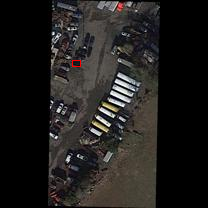

In [ ]:
#잘 찍히는 것을 확인할 수 있다.
from google.colab.patches import cv2_imshow


img=cv2.imread('/content/gdrive/MyDrive/dataset/test_image.jpg')
'''
x1y1  x2y2
x3y3  x4y4
'''
x1=int(x-w/2)
x2=int(x+w/2)
x3=int(x-w/2)
x4=int(x+w/2)

y1=int(y-h/2)
y2=int(y-h/2)
y3=int(y+h/2)
y4=int(y+h/2)

cv2.line(img, (x1, y1), (x2, y2), (0,0,255),1) # 두께 5
cv2.line(img, (x2, y2), (x4, y4), (0,0,255),1)
cv2.line(img, (x3, y3), (x4, y4), (0,0,255),1)
cv2.line(img, (x3, y3), (x1, y1),(0,0,255), 1)


# 영상 출력
cv2_imshow(img)